# About this notebook
Data sources:
- HDB Resale Prices Dataset

API Services used:
- OneMap API

Purpose:
1. Can we predict the price of a resale flat based on all the attributes mentioned above?
Metric: Root-Mean-Square
2. What features of a flat best predicts its resale price?
Eg. Is it no. of rooms? Or floor_area_sqm?
3. What type of nearby amenities significantly increase the price of a resale flat?
Eg. is it MRT station?


# Setup

In [1]:
# Install additional packages
# !pip install googlemaps
!pip install dython

# Importing packages

import math
from dython.nominal import associations
import pickle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Notebook options
pd.options.display.width = 0
pd.set_option("expand_frame_repr", False)
pd.options.display.max_columns = None
sns.set() # set the default Seaborn style for graphics

# Helper Functions

In [3]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [4]:
def boxplot_sorted(df, by, column, **kwargs):
  """
  To assist in plotting boxplots, ordered by ascending median
  """
  # use dict comprehension to create new dataframe from the iterable groupby object
  # each group name becomes a column in the new dataframe
  df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
  # find and sort the median values in this new dataframe
  meds = df2.median().sort_values()
  # use the columns in the dataframe, ordered sorted by median value
  # return axes so changes can be made outside the function
  return df2[meds.index].boxplot(return_type="axes", **kwargs)

In [5]:
def custom_get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            print("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = custom_get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

# Analysis Options

In [12]:
# Analyse flats that are sold within a certain range
START_DATE = "2019-01-01"
END_DATE = "2020-12-31"
SEED = 42

# Importing Data

In [ ]:
flats_raw = pd.read_csv("resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv") # Flat resale listings
flats_latlong = pd.read_csv("flats_latlong.csv", index_col=0) # Flat location data (unique addresses)
mrt_latlong = pd.read_csv("mrt_latlong.csv", index_col=0) # MRT location data
hospitals_latlong = pd.read_csv("hospitals_latlong.csv", index_col=0) # Hospital location data
schools_latlong = pd.read_csv("schools_latlong.csv", index_col=0) # School location data

In [ ]:
print(flats_raw.info())
flats_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124003 entries, 0 to 124002
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                124003 non-null  object 
 1   town                 124003 non-null  object 
 2   flat_type            124003 non-null  object 
 3   block                124003 non-null  object 
 4   street_name          124003 non-null  object 
 5   storey_range         124003 non-null  object 
 6   floor_area_sqm       124003 non-null  float64
 7   flat_model           124003 non-null  object 
 8   lease_commence_date  124003 non-null  int64  
 9   remaining_lease      124003 non-null  object 
 10  resale_price         124003 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 10.4+ MB
None


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [ ]:
print(flats_latlong.info())
flats_latlong.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9216 entries, 0 to 9215
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   street_name  9216 non-null   object 
 1   block        9216 non-null   object 
 2   lat          9216 non-null   float64
 3   long         9216 non-null   float64
dtypes: float64(2), object(2)
memory usage: 360.0+ KB
None


,street_name,block,lat,long
0,ADMIRALTY DR,353A,1.450538,103.819135
1,ADMIRALTY DR,353B,1.450165,103.819307
2,ADMIRALTY DR,353C,1.449758,103.819449
3,ADMIRALTY DR,354A,1.450066,103.818891
4,ADMIRALTY DR,354B,1.450399,103.818681


In [ ]:
print(mrt_latlong.info())
mrt_latlong.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166 entries, 0 to 165
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station_name  166 non-null    object 
 1   lat           166 non-null    float64
 2   long          166 non-null    float64
 3   number_lines  166 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 6.5+ KB
None


,station_name,lat,long,number_lines
0,ADMIRALTY MRT STATION,1.440585,103.800998,1
1,ALJUNIED MRT STATION,1.316433,103.882893,1
2,ANG MO KIO MRT STATION,1.369933,103.849553,1
3,BAKAU LRT STATION,1.388093,103.905418,1
4,BANGKIT LRT STATION,1.380018,103.772667,1


In [ ]:
print(hospitals_latlong.info())
hospitals_latlong.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         30 non-null     object 
 1   Address      30 non-null     object 
 2   lat          30 non-null     float64
 3   long         30 non-null     float64
 4   postal_code  30 non-null     object 
dtypes: float64(2), object(3)
memory usage: 1.4+ KB
None


,Name,Address,lat,long,postal_code
0,ALEXANDRA HOSPITAL,378 ALEXANDRA ROAD Singapore 159964,1.288598,103.799974,Singapore 159964
1,ANG MO KIO - THYE HUA KWAN HOSPITAL,17 ANG MO KIO AVENUE 9 Singapore 569766,1.384019,103.840356,Singapore 569766
2,BRIGHT VISION HOSPITAL,5 LORONG NAPIRI Singapore 547530,1.371946,103.878033,Singapore 547530
3,CHANGI GENERAL HOSPITAL,2 SIMEI STREET 3 Singapore 529889,1.340531,103.949633,Singapore 529889
4,COMPLEX MEDICAL CENTRE,982 UPPER CHANGI ROAD NORTH Singapore 507709,1.357902,103.971309,Singapore 507709


In [ ]:
print(schools_latlong.info())
schools_latlong.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346 entries, 0 to 345
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   school_name  346 non-null    object 
 1   address      346 non-null    object 
 2   postal_code  346 non-null    int64  
 3   school_type  346 non-null    object 
 4   lat          346 non-null    float64
 5   long         346 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ KB
None


,school_name,address,postal_code,school_type,lat,long
0,ADMIRALTY PRIMARY SCHOOL,11 WOODLANDS CIRCLE,738907,PRIMARY,1.442986,103.800305
1,ADMIRALTY SECONDARY SCHOOL,31 WOODLANDS CRESCENT,737916,SECONDARY,1.445891,103.802398
2,AHMAD IBRAHIM PRIMARY SCHOOL,10 YISHUN STREET 11,768643,PRIMARY,1.433681,103.832924
3,AHMAD IBRAHIM SECONDARY SCHOOL,751 YISHUN AVENUE 7,768928,SECONDARY,1.436235,103.829986
4,AI TONG SCHOOL,100 Bright Hill Drive,579646,PRIMARY,1.360736,103.833076


# Joining and getting Haversine distance

In [ ]:
def get_closest(flats_latlong_df, amenity_latlong_df, amenity_type, amenity_colname):
  """
  Calculate the closest amenity specified in terms of haversine distance
  """
  cols = flats_latlong_df.columns.tolist()
  df = flats_latlong_df.merge(amenity_latlong_df, how="cross")
  df[f"{amenity_type}_distance"] = df.loc[:, ["lat_x", "long_x", "lat_y", "long_y"]].apply(lambda row: haversine(row["long_x"], row["lat_x"], row["long_y"], row["lat_y"]), axis=1)
  df_closest = df.loc[df.groupby(["street_name", "block"])[f"{amenity_type}_distance"].idxmin()]
  df_closest = df_closest.rename(columns={amenity_colname: f"closest_{amenity_type}", "lat_x": "lat", "long_x": "long"})
  return df_closest[[*cols, f"closest_{amenity_type}", f"{amenity_type}_distance"]]

# For each unique flat location, get the closest MRT, hospital, school
location_combined = get_closest(flats_latlong, mrt_latlong, "mrt", "station_name")
location_combined = get_closest(location_combined, hospitals_latlong, "hospital", "Name")
location_combined = get_closest(location_combined, schools_latlong, "school", "school_name")

# Get additional columns from amenity dataframes
location_combined = location_combined.merge(mrt_latlong[["station_name", "number_lines"]], left_on="closest_mrt", right_on="station_name").drop("station_name", axis=1)
location_combined = location_combined.merge(schools_latlong[["school_name", "school_type"]], left_on="closest_school", right_on="school_name").drop("school_name", axis=1)

location_combined.head()

,street_name,block,lat,long,closest_mrt,mrt_distance,closest_hospital,hospital_distance,closest_school,school_distance,number_lines,school_type
0,ADMIRALTY DR,353A,1.450538,103.819135,SEMBAWANG MRT STATION,0.194104,YISHUN COMMUNITY HOSPITAL,3.588494,CANBERRA PRIMARY SCHOOL,0.381610,1,PRIMARY
1,ADMIRALTY DR,354A,1.450066,103.818891,SEMBAWANG MRT STATION,0.171334,YISHUN COMMUNITY HOSPITAL,3.561071,CANBERRA PRIMARY SCHOOL,0.362946,1,PRIMARY
2,ADMIRALTY DR,354B,1.450399,103.818681,SEMBAWANG MRT STATION,0.213646,YISHUN COMMUNITY HOSPITAL,3.604771,CANBERRA PRIMARY SCHOOL,0.333104,1,PRIMARY
3,ADMIRALTY DR,354C,1.450644,103.818249,SEMBAWANG MRT STATION,0.267352,YISHUN COMMUNITY HOSPITAL,3.654848,CANBERRA PRIMARY SCHOOL,0.282506,1,PRIMARY
4,ADMIRALTY DR,354D,1.450784,103.818645,SEMBAWANG MRT STATION,0.248084,YISHUN COMMUNITY HOSPITAL,3.642075,CANBERRA PRIMARY SCHOOL,0.325810,1,PRIMARY


In [ ]:
# Joining with each flat listing
flats_combined = flats_raw.merge(location_combined, on=["street_name", "block"])
print(flats_combined.info())
flats_combined.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124003 entries, 0 to 124002
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                124003 non-null  object 
 1   town                 124003 non-null  object 
 2   flat_type            124003 non-null  object 
 3   block                124003 non-null  object 
 4   street_name          124003 non-null  object 
 5   storey_range         124003 non-null  object 
 6   floor_area_sqm       124003 non-null  float64
 7   flat_model           124003 non-null  object 
 8   lease_commence_date  124003 non-null  int64  
 9   remaining_lease      124003 non-null  object 
 10  resale_price         124003 non-null  float64
 11  lat                  124003 non-null  float64
 12  long                 124003 non-null  float64
 13  closest_mrt          124003 non-null  object 
 14  mrt_distance         124003 non-null  float64
 15  closest_hospital 

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,lat,long,closest_mrt,mrt_distance,closest_hospital,hospital_distance,closest_school,school_distance,number_lines,school_type
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272,ANG MO KIO - THYE HUA KWAN HOSPITAL,2.872726,TOWNSVILLE PRIMARY SCHOOL,0.229176,1,PRIMARY
1,2017-05,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 01 month,235000.0,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272,ANG MO KIO - THYE HUA KWAN HOSPITAL,2.872726,TOWNSVILLE PRIMARY SCHOOL,0.229176,1,PRIMARY
2,2018-03,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,60 years 02 months,202000.0,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272,ANG MO KIO - THYE HUA KWAN HOSPITAL,2.872726,TOWNSVILLE PRIMARY SCHOOL,0.229176,1,PRIMARY
3,2018-03,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,60 years 02 months,210000.0,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272,ANG MO KIO - THYE HUA KWAN HOSPITAL,2.872726,TOWNSVILLE PRIMARY SCHOOL,0.229176,1,PRIMARY
4,2018-05,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,07 TO 09,44.0,Improved,1979,60 years 01 month,220000.0,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272,ANG MO KIO - THYE HUA KWAN HOSPITAL,2.872726,TOWNSVILLE PRIMARY SCHOOL,0.229176,1,PRIMARY


# Further cleaning

In [ ]:
# Fixing datatypes
flats_combined["date"] = pd.to_datetime(flats_combined["month"], format='%Y-%M')
for col in ["town", "flat_type", "storey_range", "flat_model", "school_type"]:
  flats_combined[col] = flats_combined[col].astype('category')

flats_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124003 entries, 0 to 124002
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   month                124003 non-null  object        
 1   town                 124003 non-null  category      
 2   flat_type            124003 non-null  category      
 3   block                124003 non-null  object        
 4   street_name          124003 non-null  object        
 5   storey_range         124003 non-null  category      
 6   floor_area_sqm       124003 non-null  float64       
 7   flat_model           124003 non-null  category      
 8   lease_commence_date  124003 non-null  int64         
 9   remaining_lease      124003 non-null  object        
 10  resale_price         124003 non-null  float64       
 11  lat                  124003 non-null  float64       
 12  long                 124003 non-null  float64       
 13  closest_mrt   

In [ ]:
# Converting remaining_lease to years remaining
flats_combined["remaining_lease"] = flats_combined["date"].dt.year - flats_combined["lease_commence_date"]

# Convert storey_range to a single integer which is the middle of each range
flats_combined["storey_mid"] = pd.to_numeric(flats_combined["storey_range"].apply(lambda x: (int(x.split()[0]) + int(x.split()[2])) / 2))

# Convert distances to metres instead of km
for col in ["mrt_distance", "hospital_distance", "school_distance"]:
  flats_combined[f"{col}_m"] = flats_combined[col] * 1000

flats_combined.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,lat,long,closest_mrt,mrt_distance,closest_hospital,hospital_distance,closest_school,school_distance,number_lines,school_type,date,storey_mid,mrt_distance_m,hospital_distance_m,school_distance_m
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,38,232000.0,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272,ANG MO KIO - THYE HUA KWAN HOSPITAL,2.872726,TOWNSVILLE PRIMARY SCHOOL,0.229176,1,PRIMARY,2017-01-01 00:01:00,11.0,1004.272128,2872.726378,229.176034
1,2017-05,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,38,235000.0,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272,ANG MO KIO - THYE HUA KWAN HOSPITAL,2.872726,TOWNSVILLE PRIMARY SCHOOL,0.229176,1,PRIMARY,2017-01-01 00:05:00,11.0,1004.272128,2872.726378,229.176034
2,2018-03,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,39,202000.0,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272,ANG MO KIO - THYE HUA KWAN HOSPITAL,2.872726,TOWNSVILLE PRIMARY SCHOOL,0.229176,1,PRIMARY,2018-01-01 00:03:00,2.0,1004.272128,2872.726378,229.176034
3,2018-03,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,39,210000.0,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272,ANG MO KIO - THYE HUA KWAN HOSPITAL,2.872726,TOWNSVILLE PRIMARY SCHOOL,0.229176,1,PRIMARY,2018-01-01 00:03:00,2.0,1004.272128,2872.726378,229.176034
4,2018-05,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,07 TO 09,44.0,Improved,1979,39,220000.0,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272,ANG MO KIO - THYE HUA KWAN HOSPITAL,2.872726,TOWNSVILLE PRIMARY SCHOOL,0.229176,1,PRIMARY,2018-01-01 00:05:00,8.0,1004.272128,2872.726378,229.176034


In [ ]:
# Selecting only needed columns
col_list = ["date","block","street_name","town","flat_type","storey_mid", "floor_area_sqm","flat_model","remaining_lease","resale_price","closest_mrt","mrt_distance_m","number_lines","closest_hospital","hospital_distance_m","closest_school","school_distance_m","school_type"]
flats = flats_combined[col_list].copy()
print(flats.info())
flats.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124003 entries, 0 to 124002
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 124003 non-null  datetime64[ns]
 1   block                124003 non-null  object        
 2   street_name          124003 non-null  object        
 3   town                 124003 non-null  category      
 4   flat_type            124003 non-null  category      
 5   storey_mid           124003 non-null  float64       
 6   floor_area_sqm       124003 non-null  float64       
 7   flat_model           124003 non-null  category      
 8   remaining_lease      124003 non-null  int64         
 9   resale_price         124003 non-null  float64       
 10  closest_mrt          124003 non-null  object        
 11  mrt_distance_m       124003 non-null  float64       
 12  number_lines         124003 non-null  int64         
 13  closest_hospit

,date,block,street_name,town,flat_type,storey_mid,floor_area_sqm,flat_model,remaining_lease,resale_price,closest_mrt,mrt_distance_m,number_lines,closest_hospital,hospital_distance_m,closest_school,school_distance_m,school_type
0,2017-01-01 00:01:00,406,ANG MO KIO AVE 10,ANG MO KIO,2 ROOM,11.0,44.0,Improved,38,232000.0,ANG MO KIO MRT STATION,1004.272128,1,ANG MO KIO - THYE HUA KWAN HOSPITAL,2872.726378,TOWNSVILLE PRIMARY SCHOOL,229.176034,PRIMARY
1,2017-01-01 00:05:00,406,ANG MO KIO AVE 10,ANG MO KIO,2 ROOM,11.0,44.0,Improved,38,235000.0,ANG MO KIO MRT STATION,1004.272128,1,ANG MO KIO - THYE HUA KWAN HOSPITAL,2872.726378,TOWNSVILLE PRIMARY SCHOOL,229.176034,PRIMARY
2,2018-01-01 00:03:00,406,ANG MO KIO AVE 10,ANG MO KIO,2 ROOM,2.0,44.0,Improved,39,202000.0,ANG MO KIO MRT STATION,1004.272128,1,ANG MO KIO - THYE HUA KWAN HOSPITAL,2872.726378,TOWNSVILLE PRIMARY SCHOOL,229.176034,PRIMARY
3,2018-01-01 00:03:00,406,ANG MO KIO AVE 10,ANG MO KIO,2 ROOM,2.0,44.0,Improved,39,210000.0,ANG MO KIO MRT STATION,1004.272128,1,ANG MO KIO - THYE HUA KWAN HOSPITAL,2872.726378,TOWNSVILLE PRIMARY SCHOOL,229.176034,PRIMARY
4,2018-01-01 00:05:00,406,ANG MO KIO AVE 10,ANG MO KIO,2 ROOM,8.0,44.0,Improved,39,220000.0,ANG MO KIO MRT STATION,1004.272128,1,ANG MO KIO - THYE HUA KWAN HOSPITAL,2872.726378,TOWNSVILLE PRIMARY SCHOOL,229.176034,PRIMARY


In [13]:
# Temporary Export

# Pickle
# file_to_dump = open('flats_clean', 'wb') # Pickling the object
# pickle.dump(flats, file_to_dump)
# file_to_dump.close()
file_to_load = open('flats_clean', 'rb')
flats = pickle.load(file_to_load)  # Unpickling the object
file_to_load.close()

# CSV
# flats.to_csv("flats_clean.csv", index=False)
# flats = pd.read_csv("flats_clean.csv", dtype=flats.drop("date", axis=1).dtypes.to_dict(), parse_dates=["date"])

# Verify
print(flats.info())
flats.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124003 entries, 0 to 124002
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 124003 non-null  datetime64[ns]
 1   block                124003 non-null  object        
 2   street_name          124003 non-null  object        
 3   town                 124003 non-null  category      
 4   flat_type            124003 non-null  category      
 5   storey_mid           124003 non-null  float64       
 6   floor_area_sqm       124003 non-null  float64       
 7   flat_model           124003 non-null  category      
 8   remaining_lease      124003 non-null  int64         
 9   resale_price         124003 non-null  float64       
 10  closest_mrt          124003 non-null  object        
 11  mrt_distance_m       124003 non-null  float64       
 12  number_lines         124003 non-null  int64         
 13  closest_hospit

,date,block,street_name,town,flat_type,storey_mid,floor_area_sqm,flat_model,remaining_lease,resale_price,closest_mrt,mrt_distance_m,number_lines,closest_hospital,hospital_distance_m,closest_school,school_distance_m,school_type
0,2017-01-01 00:01:00,406,ANG MO KIO AVE 10,ANG MO KIO,2 ROOM,11.0,44.0,Improved,38,232000.0,ANG MO KIO MRT STATION,1004.272128,1,ANG MO KIO - THYE HUA KWAN HOSPITAL,2872.726378,TOWNSVILLE PRIMARY SCHOOL,229.176034,PRIMARY
1,2017-01-01 00:05:00,406,ANG MO KIO AVE 10,ANG MO KIO,2 ROOM,11.0,44.0,Improved,38,235000.0,ANG MO KIO MRT STATION,1004.272128,1,ANG MO KIO - THYE HUA KWAN HOSPITAL,2872.726378,TOWNSVILLE PRIMARY SCHOOL,229.176034,PRIMARY
2,2018-01-01 00:03:00,406,ANG MO KIO AVE 10,ANG MO KIO,2 ROOM,2.0,44.0,Improved,39,202000.0,ANG MO KIO MRT STATION,1004.272128,1,ANG MO KIO - THYE HUA KWAN HOSPITAL,2872.726378,TOWNSVILLE PRIMARY SCHOOL,229.176034,PRIMARY
3,2018-01-01 00:03:00,406,ANG MO KIO AVE 10,ANG MO KIO,2 ROOM,2.0,44.0,Improved,39,210000.0,ANG MO KIO MRT STATION,1004.272128,1,ANG MO KIO - THYE HUA KWAN HOSPITAL,2872.726378,TOWNSVILLE PRIMARY SCHOOL,229.176034,PRIMARY
4,2018-01-01 00:05:00,406,ANG MO KIO AVE 10,ANG MO KIO,2 ROOM,8.0,44.0,Improved,39,220000.0,ANG MO KIO MRT STATION,1004.272128,1,ANG MO KIO - THYE HUA KWAN HOSPITAL,2872.726378,TOWNSVILLE PRIMARY SCHOOL,229.176034,PRIMARY


# Data Exploration

In [14]:
# Defining range/time period of analysis
mask = (flats['date'] > START_DATE) & (flats['date'] <= END_DATE)
flats_analyse = flats.loc[mask]
print(f"Currently analysing {len(flats_analyse)} flats out of {len(flats)} total flats")

Currently analysing 45519 flats out of 124003 total flats


In [15]:
# Summary Statistics
flats_analyse.describe()

,storey_mid,floor_area_sqm,remaining_lease,resale_price,mrt_distance_m,number_lines,hospital_distance_m,school_distance_m
count,45519.000000,45519.000000,45519.000000,4.551900e+04,45519.000000,45519.000000,45519.000000,45519.000000
mean,8.575957,97.360212,24.100991,4.424624e+05,629.098935,1.090885,2312.566737,316.772350
std,5.754500,24.329811,13.699753,1.545714e+05,390.561359,0.287449,1560.507479,176.728260
min,2.000000,31.000000,1.000000,1.400000e+05,22.419695,1.000000,70.800118,0.000000
25%,5.000000,82.000000,11.000000,3.300000e+05,326.398763,1.000000,1165.671477,191.840785
50%,8.000000,93.000000,24.000000,4.150000e+05,554.339294,1.000000,1876.620811,281.414261
75%,11.000000,112.000000,35.000000,5.220000e+05,841.095270,1.000000,2952.815045,401.206094
max,50.000000,192.000000,54.000000,1.258000e+06,3535.264056,2.000000,7740.589949,3296.561283


<Figure size 432x288 with 0 Axes>

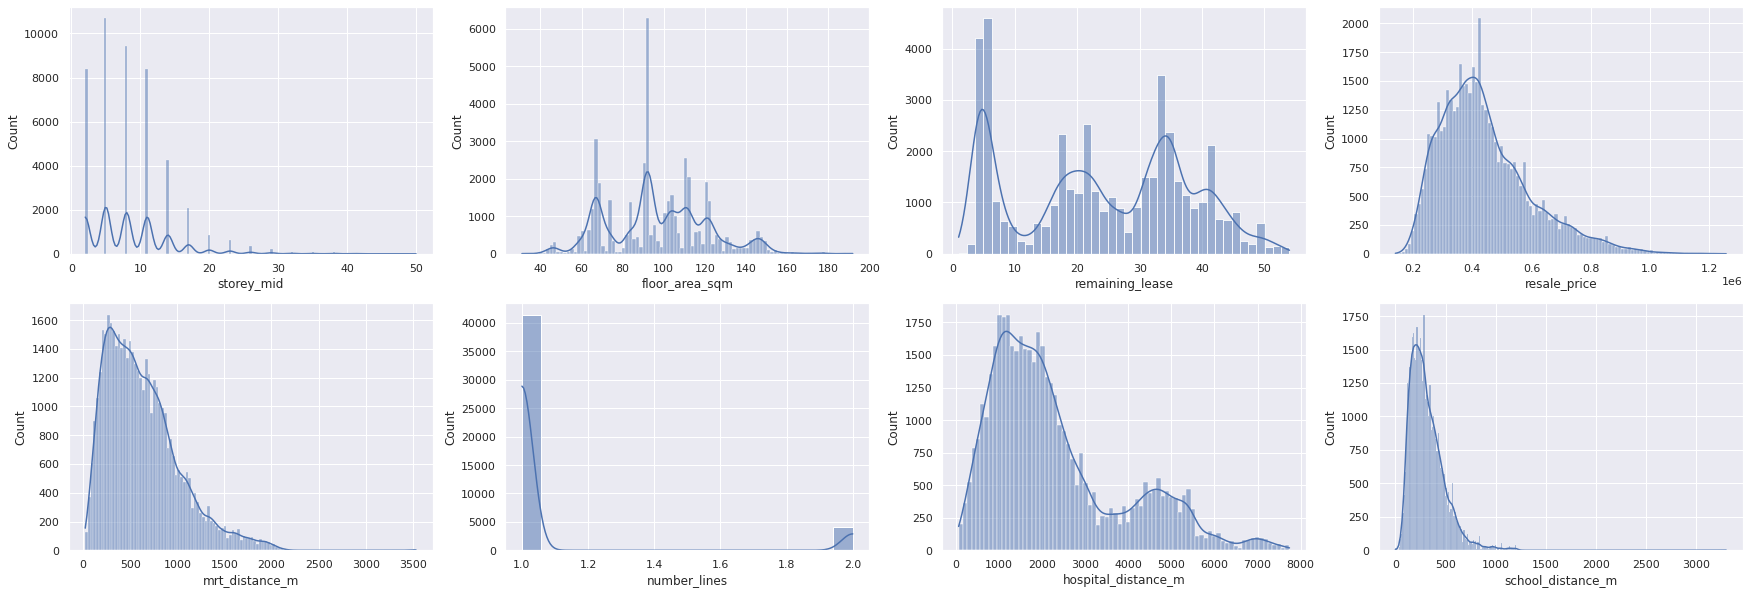

In [16]:
# Plotting distributions of numeric variables
plt.clf()
fig, ax = plt.subplots(2,4, figsize=(30,10))
for i, column in enumerate(flats_analyse.select_dtypes(include='number')):
    sns.histplot(flats_analyse[column], kde=True, ax=ax[i//4,i%4])

<Figure size 432x288 with 0 Axes>

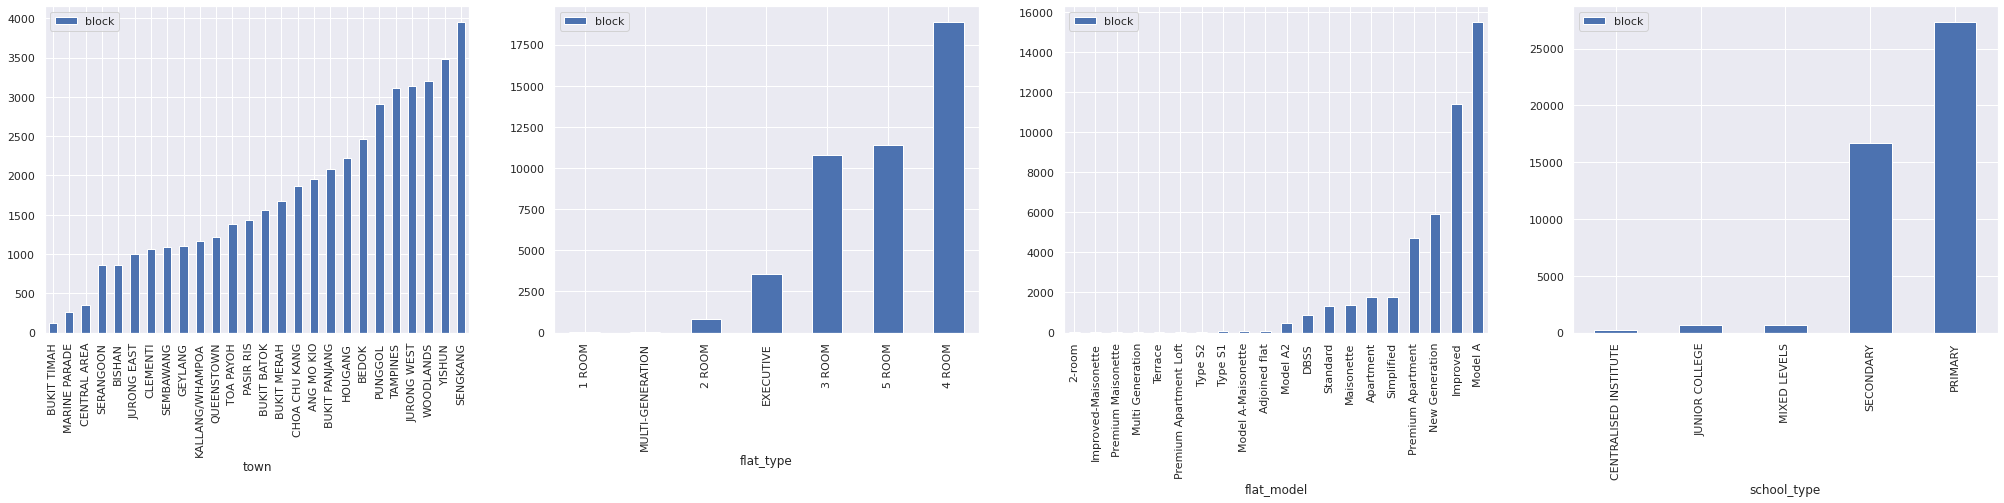

In [17]:
# Plotting distributions of categorical variables
plt.clf()
fig, ax = plt.subplots(1,4, figsize=(35,6))
for i, col in enumerate(flats_analyse.select_dtypes(include='category')):
  flats_analyse.groupby(col).count().sort_values("block").reset_index().plot.bar(x=col, y="block", ax=ax[i])

# plt.tight_layout()

# Data Analysis / Machine Learning
- Now that the data is fully cleaned and merged in this notebook, this part will focus on answering the questions that we have posed.

## Q1: Predicting Resale Flat Prices
Can we predict the price of a resale flat based on the attributes we have gathered? Metric: Root-Mean-Square

Intercept 	: b =  [55256.29369459]
Coefficients 	: a =  [[3978.41495235]]


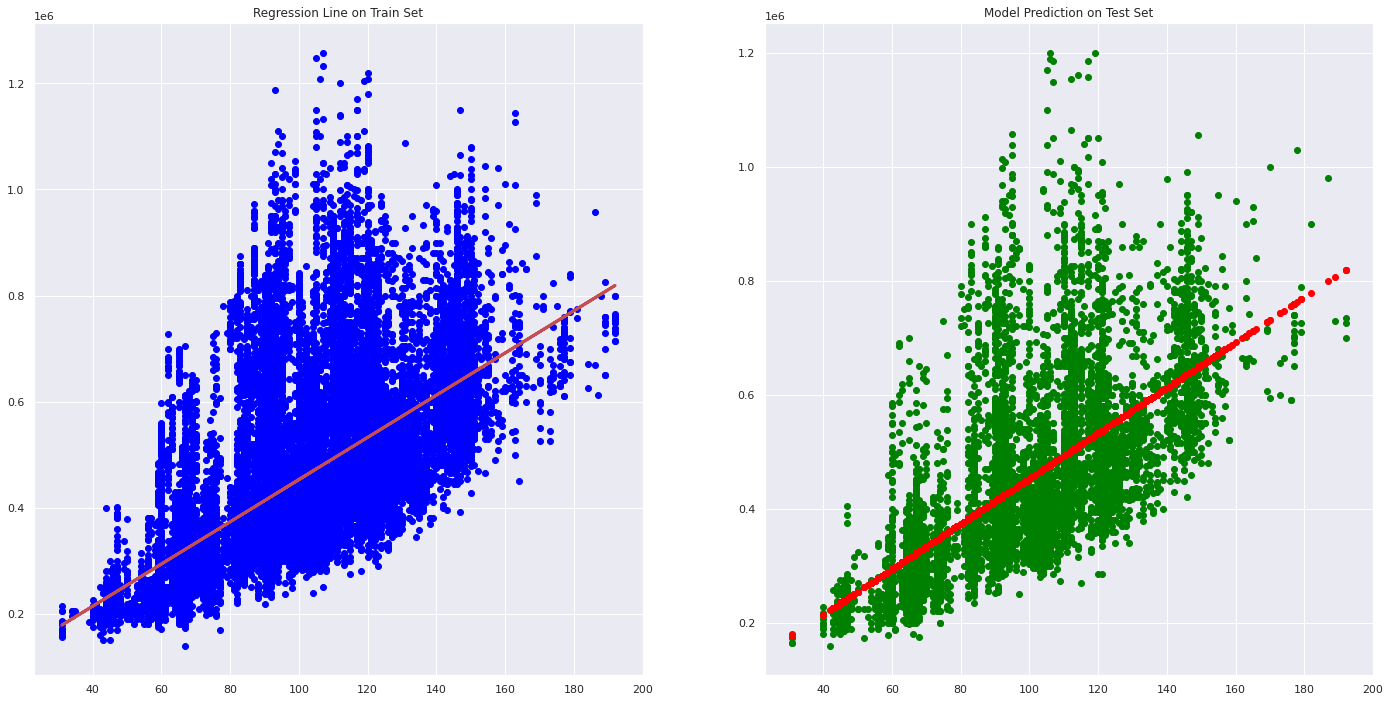

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.3911023651430764
Mean Squared Error (MSE) 	: 14543521870.748772

Prediction Accuracy of Model 	Test Dataset
Mean Squared Error (MSE) 	: 118417.90299271731

Feature: 0, Score: 3978.41495
Intercept 	: b =  [533545.76311146]
Coefficients 	: a =  [[-3769.53757704]]


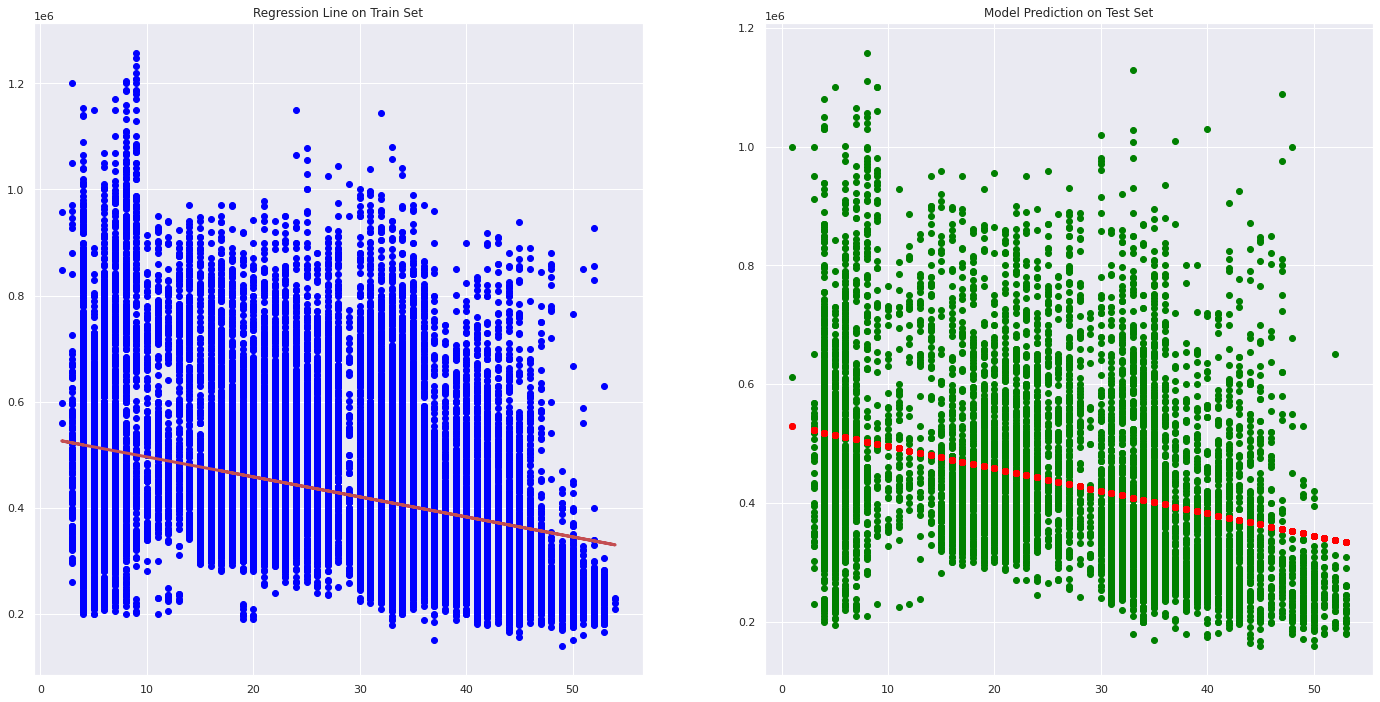

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.1114523316501419
Mean Squared Error (MSE) 	: 21261641753.186474

Prediction Accuracy of Model 	Test Dataset
Mean Squared Error (MSE) 	: 145816.61672644308

Feature: 0, Score: -3769.53758
Intercept 	: b =  [359315.26931941]
Coefficients 	: a =  [[9714.15557861]]


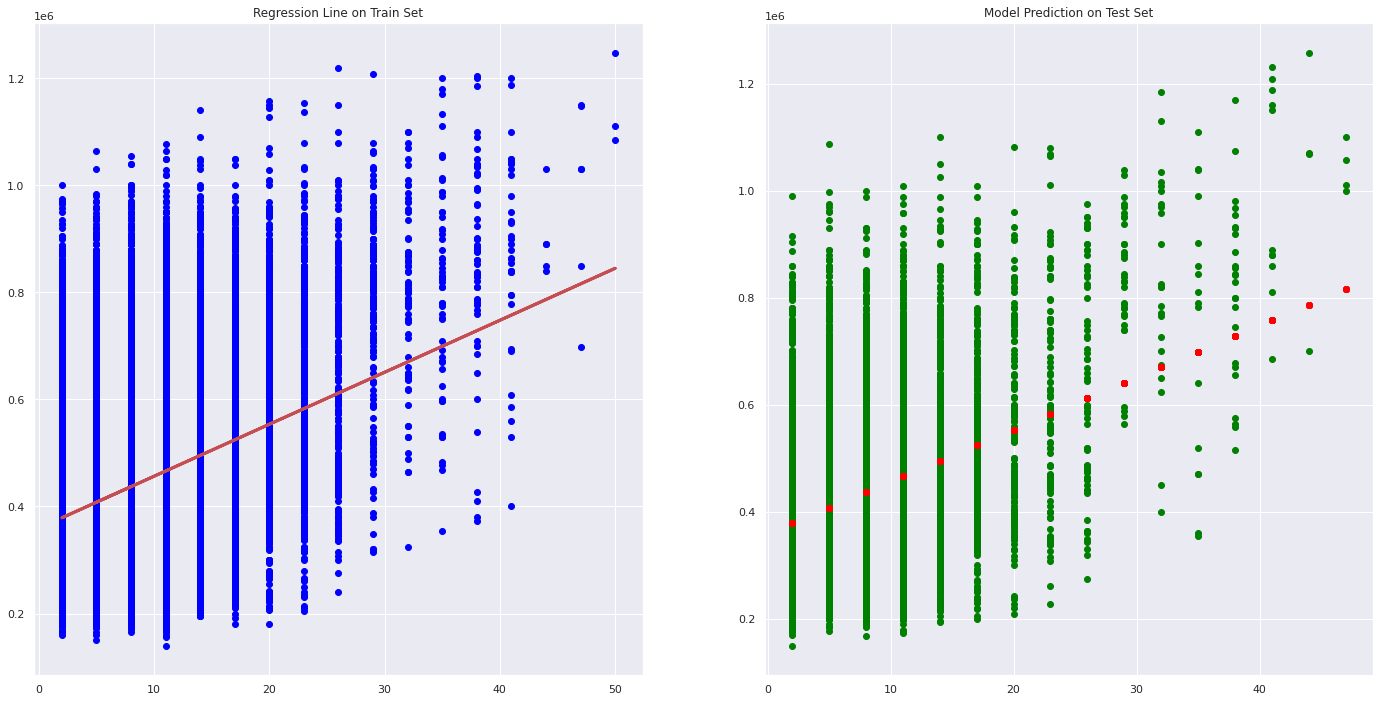

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.12945116438983295
Mean Squared Error (MSE) 	: 20808271695.561127

Prediction Accuracy of Model 	Test Dataset
Mean Squared Error (MSE) 	: 143159.50450551693

Feature: 0, Score: 9714.15558


In [18]:
#Do linear regression for the continuous variables available in the dataset.

linreg = LinearRegression()

data = flats_analyse

#generic function to do linear regression.
def univariateLinearRegression(Xvar = None, yvar = None, df = None):
    '''
        Function to perform Linear Regression with Xvar and yvar in df.
        Prints the required plots within the function. Returns nothing.
    '''    
    # Extract Response and Predictors
    y = pd.DataFrame(df[yvar])
    X = pd.DataFrame(df[Xvar])

    # Split the Dataset into random Train and Test (80:20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    linreg = LinearRegression()         # create the linear regression object
    linreg.fit(X_train, y_train)        # train the linear regression model

    # Print the coefficients of the Regression Line
    print('Intercept \t: b = ', linreg.intercept_)
    print('Coefficients \t: a = ', linreg.coef_)
    
    # Formula for the Regression line
    regline_x = X_train
    regline_y = linreg.intercept_ + linreg.coef_ * X_train
    
    # Predict Response corresponding to Predictors
    y_train_pred = linreg.predict(X_train)
    y_test_pred = linreg.predict(X_test)
    
    # Plot the Predictions vs the True values
    f, axes = plt.subplots(1, 2, figsize=(24, 12))
    axes[0].scatter(X_train, y_train, color = "blue")
    axes[0].plot(regline_x, regline_y, 'r-', linewidth = 3)
    axes[0].set_title("Regression Line on Train Set")
    axes[1].scatter(X_test, y_test, color = "green")
    axes[1].scatter(X_test, y_test_pred, color = "red")
    axes[1].set_title("Model Prediction on Test Set")
    plt.show()

    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Prediction Accuracy of Model \tTest Dataset")
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred, squared=False))
    print()

    importance = linreg.coef_
    for i,v in enumerate(importance):
	    print('Feature: %0d, Score: %.5f' % (i,v))
  

univariateLinearRegression(Xvar = "floor_area_sqm", yvar = "resale_price", df = data)
univariateLinearRegression(Xvar = "remaining_lease", yvar = "resale_price", df = data)
univariateLinearRegression(Xvar = "storey_mid", yvar = "resale_price", df = data)

In [19]:
X_cols = ["town","flat_type","storey_mid", "floor_area_sqm","flat_model","remaining_lease","mrt_distance_m","hospital_distance_m","school_distance_m"]
X_cols_category = flats_analyse[X_cols].select_dtypes(include='category').columns.tolist()
X_cols_number = flats_analyse[X_cols].select_dtypes(include='number').columns.tolist()
y_cols = ["resale_price"]

X = pd.DataFrame(flats_analyse[X_cols])
y = pd.DataFrame(flats_analyse[y_cols])

rgrs = {"linr": LinearRegression(),
        "gbr": GradientBoostingRegressor(subsample=0.6, n_estimators=200),
}

numerical_pipe = Pipeline(
     [
      ("scaler", RobustScaler())
     ]
)

pipes = []
for name, model in rgrs.items():
  pipe = Pipeline(
      [("preprocessor", ColumnTransformer(
          transformers=[("ohe", OneHotEncoder(handle_unknown="ignore"), X_cols_category),
                        ("numerical", numerical_pipe, X_cols_number),
                        ],
          remainder='passthrough')),
        ("regressor", model)
      ]
  )

  pipes.append(pipe)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
  pipe.fit(X_train, y_train)
  print(f"{name} F1 score: %.3f" % pipe.score(X_test, y_test))
  y_pred=pipe.predict(X_test)
  print(f"{name} RMSE: %.3f" % mean_squared_error(y_test, y_pred, squared=False))
  print(f"{name} MAE: %.3f" % mean_absolute_error(y_test, y_pred))

linr F1 score: 0.889
linr RMSE: 51809.541
linr MAE: 39312.175


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gbr F1 score: 0.924
gbr RMSE: 42853.628
gbr MAE: 31524.040


### Q1 Conclusion:

Running Linear Regression on floor_area_sqm, remaining_lease and storey_mid shows that floor_area_sqm has the best chance of predicting resale price due to its lowest root MSE on the Test set.

Using SKLearn pipeline to run linear regression on all the features together further reduces RMSE to 42808; thus, these features are decently accurate at predicting resale price together.


## Q2: Most useful features of a flat to predict price
What features of a flat best predicts its resale price? Eg. Is it no. of rooms?

                     storey_mid  floor_area_sqm  remaining_lease  resale_price  mrt_distance_m  number_lines  hospital_distance_m  school_distance_m
storey_mid             1.000000       -0.013695        -0.269389      0.362891       -0.087907     -0.001165            -0.046952           0.025796
floor_area_sqm        -0.013695        1.000000        -0.115804      0.629002        0.021540      0.016487             0.144645          -0.120344
remaining_lease       -0.269389       -0.115804         1.000000     -0.331793        0.153643      0.081463            -0.083946           0.139382
resale_price           0.362891        0.629002        -0.331793      1.000000       -0.130053      0.130936            -0.138612           0.020087
mrt_distance_m        -0.087907        0.021540         0.153643     -0.130053        1.000000      0.051477            -0.028526           0.067542
number_lines          -0.001165        0.016487         0.081463      0.130936        0.051477      1.0000

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

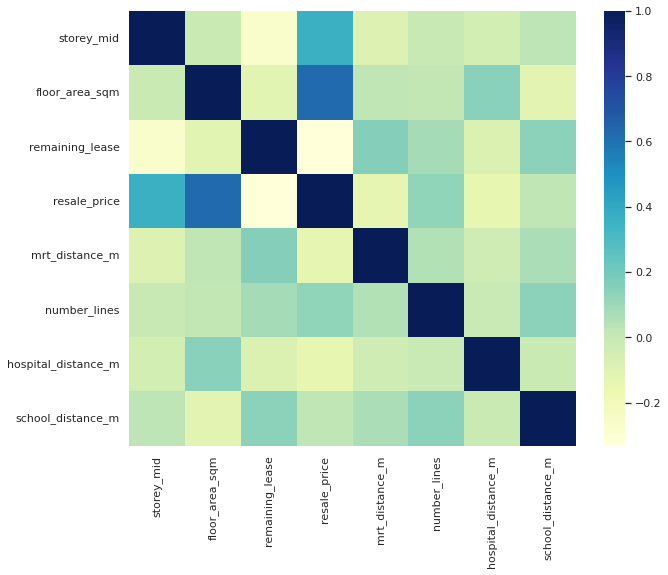

In [20]:
# Pearson correlation between resale prices and other numerical variables
pearson_flat = flats_analyse.corr(method="pearson")
print(pearson_flat)
plt.clf()
plt.figure(figsize=(10,8))
sns.heatmap(pearson_flat, cmap="YlGnBu")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


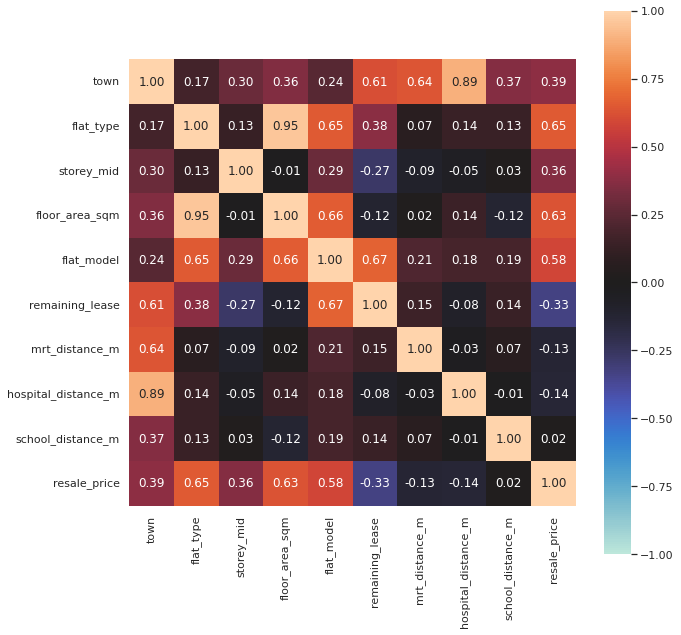

In [21]:
# Correlation Ratio for categorical - continuous relationship (weighted variance of the mean of each category divided by the variance of all samples)
cols = [*X_cols, *y_cols]
reset_typing = flats_analyse[cols]
for col in reset_typing.select_dtypes(include='category').columns.tolist():
  reset_typing[col] = reset_typing[col].astype(str)

fig = plt.figure(figsize=(10,10))
df_complete_corr = associations(reset_typing, ax=fig.gca())

Observations:
- Resale Price is most positively correlated with floor area
- Remaining lease is the only variable that is significantly negatively correlated
-Flat type is the most correlated categorical variable with resale price

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='remaining_lease', ylabel='resale_price'>

<Figure size 432x288 with 0 Axes>

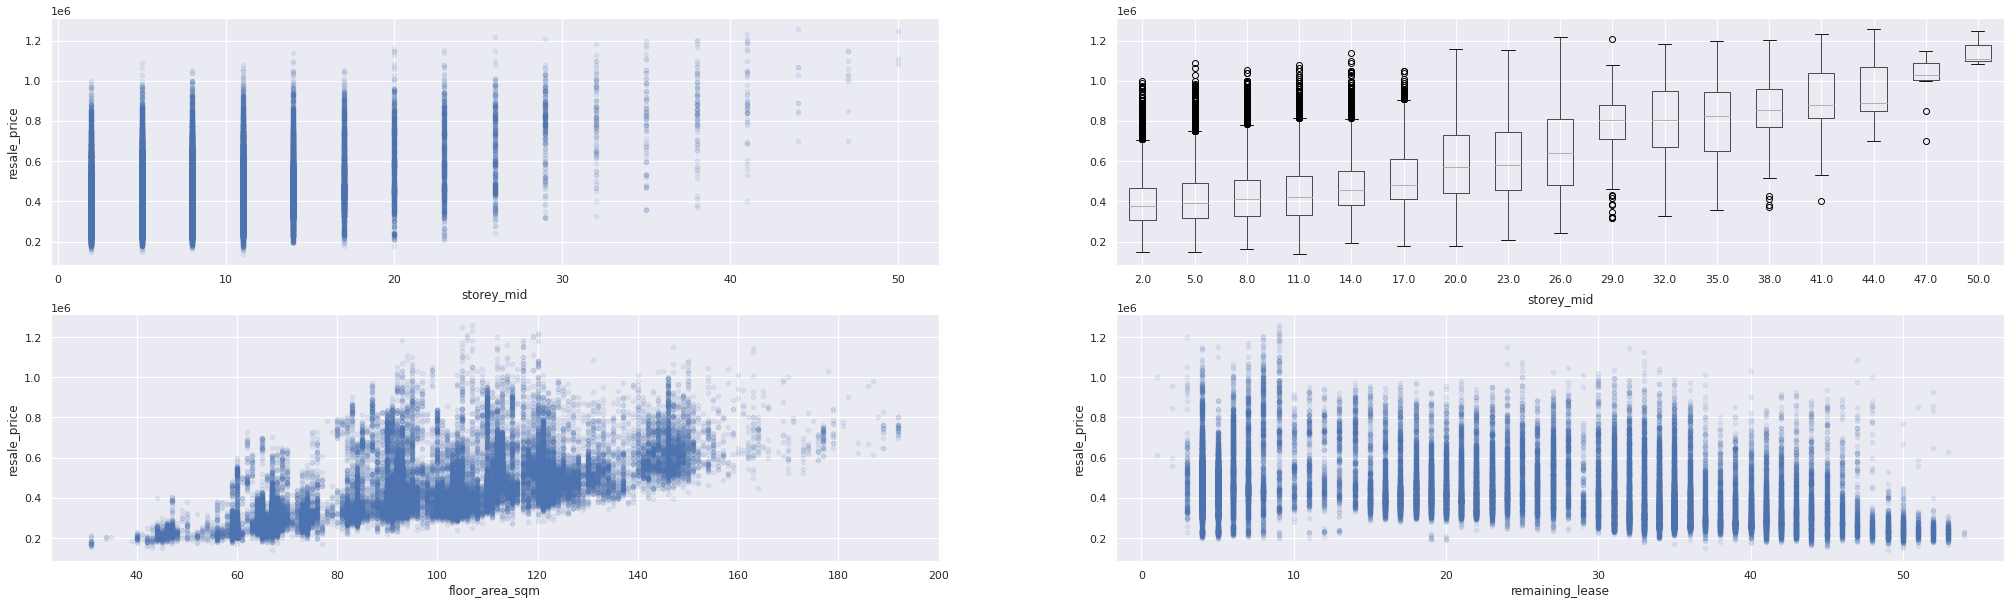

In [22]:
# Visualising correlation between resale prices and numerical variables which show medium-strong correlation
plt.clf()
fig, ax = plt.subplots(2,2, figsize=(35,10))
flats_analyse.plot.scatter(y="resale_price", x="storey_mid", alpha=0.1, ax=ax[0][0])
boxplot_sorted(flats_analyse, by=["storey_mid"], column="resale_price", ax=ax[0][1])
ax[0][1].set_title("storey_mid", y=-0.18)
flats_analyse.plot.scatter(y="resale_price", x="floor_area_sqm", alpha=0.1, ax=ax[1][0])
flats_analyse.plot.scatter(y="resale_price", x="remaining_lease", alpha=0.1, ax=ax[1][1])

Text(0.5, 1.0, 'flat_model')

<Figure size 432x288 with 0 Axes>

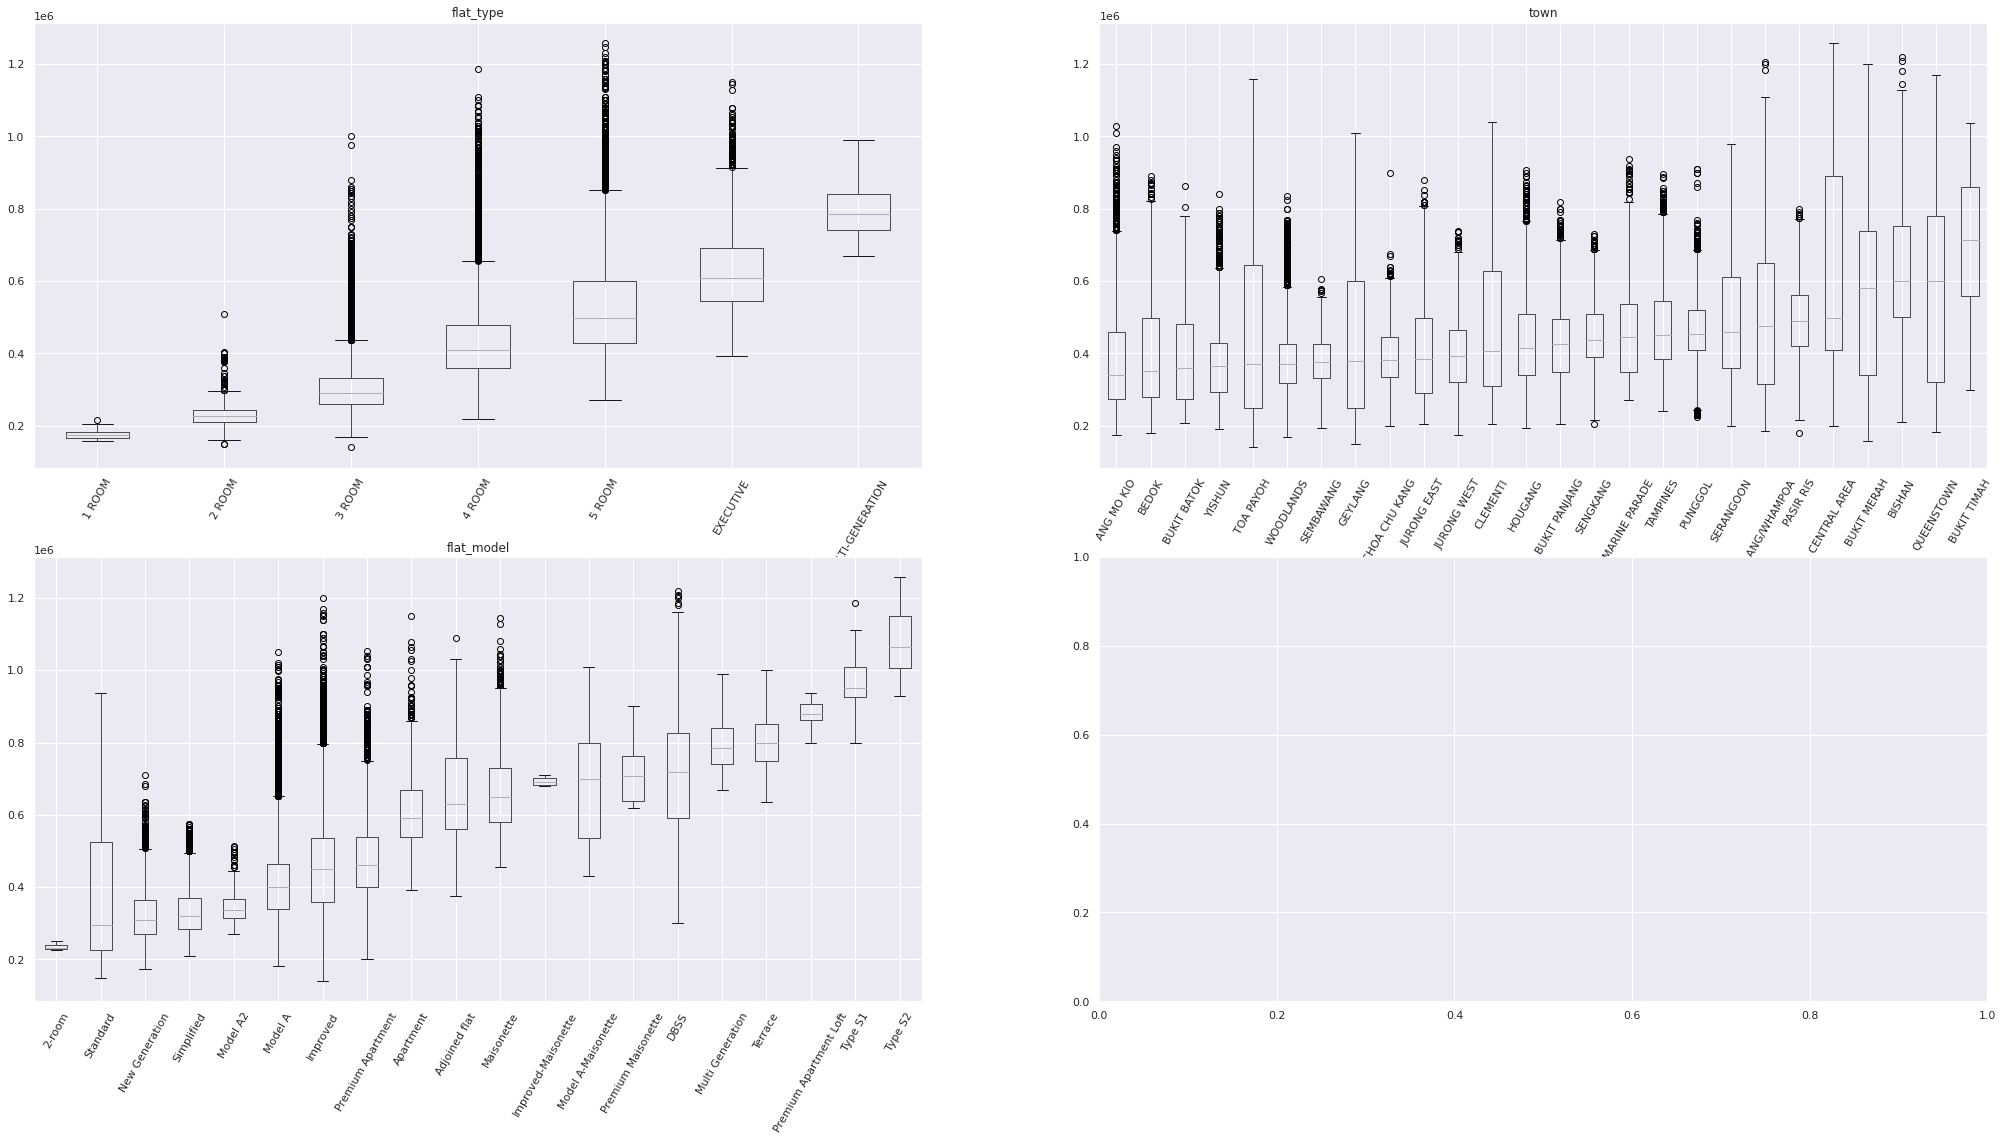

In [23]:
# Visualising correlation between resale prices and categorical variables
plt.clf()
fig, ax = plt.subplots(2,2, figsize=(35,18))
boxplot_sorted(flats_analyse, by=["flat_type"], column="resale_price", rot=60, ax=ax[0][0])
ax[0][0].set_title("flat_type")
boxplot_sorted(flats_analyse, by=["town"], column="resale_price", rot=60, ax=ax[0][1])
ax[0][1].set_title("town")
boxplot_sorted(flats_analyse, by=["flat_model"], column="resale_price", rot=60, ax=ax[1][0])
ax[1][0].set_title("flat_model")

floor_area_sqm         0.907728
town                   0.410157
remaining_lease        0.237803
hospital_distance_m    0.072944
storey_mid             0.063338
mrt_distance_m         0.041298
flat_model             0.036831
flat_type              0.024386
school_distance_m      0.002542
dtype: float64


<AxesSubplot:>

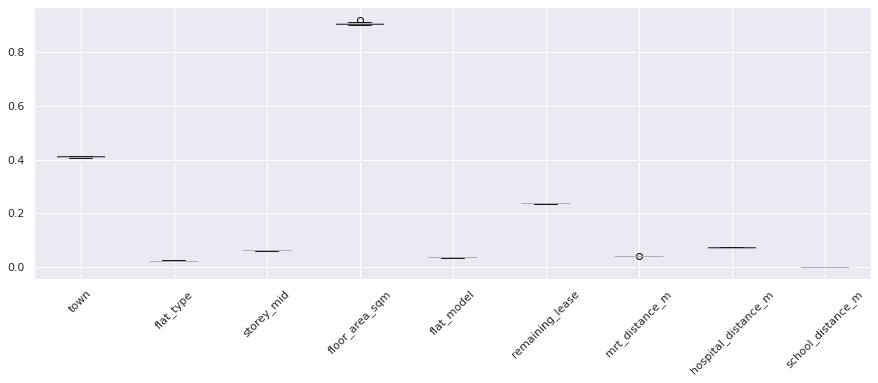

In [35]:
# 1st Approach to visualising feature importance (permutation_importance from gradient boosting model)
permutation_result = permutation_importance(pipes[1], X, y, n_repeats=10, random_state=SEED)
df_importance_permutation = pd.DataFrame(dict(zip(X_cols, permutation_result.importances)))

print(df_importance_permutation.mean().sort_values(ascending=False))
plt.figure(figsize=(15,5))
df_importance_permutation.boxplot(rot=45)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Transformer scaler (type RobustScaler) does not provide get_feature_names. Will return input column names if available


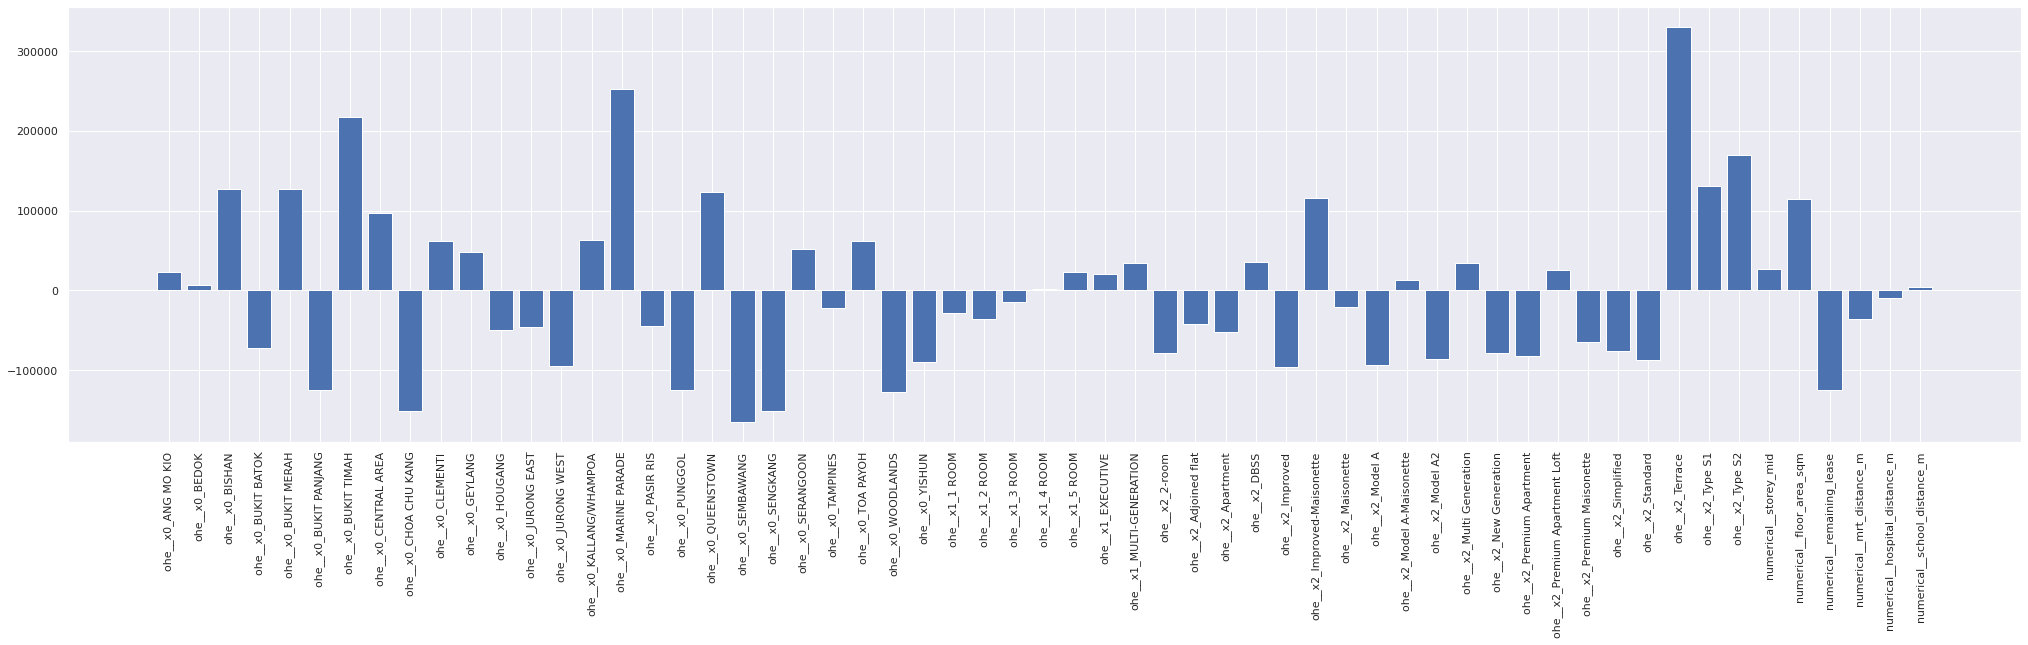

In [25]:
# 2nd approach to visualizing feature importance (.coef_ from linear regression model)
importance = pipes[0].named_steps["regressor"].coef_[0]
feature_names = custom_get_feature_names(pipes[0].named_steps['preprocessor'])

plt.figure(figsize=(35,8))
plt.bar([x for x in range(len(importance))], importance, tick_label=feature_names)
plt.xticks(rotation = 90)
plt.show()

In [26]:
# Aggregating feature importances (2nd approach)
original_features = ["ohe__x0", "ohe__x1", "ohe__x2", "storey_mid", "floor_area_sqm", "remaining_lease", "mrt_distance_m", "hospital_distance_m", "school_distance_m"]
ohe_mapping = {"ohe__x0": "town", "ohe__x1": "flat_type", "ohe__x2": "flat_model"}

def translate(x):
  for ori_name in original_features:
    if ori_name in x:
      if ori_name in ohe_mapping:
        return ohe_mapping[ori_name]
      return ori_name

df_importance = pd.DataFrame({'feature_name': feature_names, 'importance': np.abs(importance)})
df_importance["original_feature"] = df_importance["feature_name"].apply(lambda x: translate(x))
df_importance = df_importance.rename(columns=ohe_mapping)
df_importance.groupby("original_feature").mean().sort_values("importance", ascending=False)

,importance
original_feature,
remaining_lease,124526.970142
floor_area_sqm,114291.071115
town,97104.583485
flat_model,85685.667667
mrt_distance_m,36252.022160
storey_mid,27223.322452
flat_type,22641.366861
hospital_distance_m,10065.767839
school_distance_m,4546.143948


### Q2 Conclusion:

With a Pearson's Coeff of 0.629002, floor_area is the most correlated to resale prices; the coefficients of other variables (ie amenity distances) are too low to be of significance.

Floor area also had the 2nd highest feature importance, while remaining lease had the highest feature importance, although it had a far lower correlation to resale price.

The town variable can also be useful to roughly predict resale price due to its high feature importance.


## Q3: Amenities most affecting resale price
What type of nearby amenities significantly increase the price of a resale flat? Eg. is it MRT station?

As we can see from answering the previous question, resale prices are significantly affected by the characteristics of the flat and the general area they are located in: floor area, the years remaining on the lease, the storey it is on, the flat type (ie. no of rooms), the model of the flat, the relevant town.
<br>
The distances to each of the amenities have an almost insignificant effect. However, it could be that the distance variables do have an effect, just that these effects are simply dwarfed by the characteristics of the flat themselves, hence we will try to offset the effects of those characteristics.

In [30]:
amenity_cols = ["mrt_distance_m", "hospital_distance_m", "school_distance_m"]

def plot_variation(col, model, X_cols, flats_df, ax, step=50, num_steps=20):
  """
  Batch predict price for flats, using the same values for each feature EXCEPT for the distance to amenities, varying the distance to each amenity by 50m for each batch prediction
  """
  X = flats_df[X_cols]
  base_prices = model.predict(X)

  df = flats_df.loc[:,["street_name", "block", "resale_price", col]].copy().rename(columns={col: f"base_{col}"})
  df["0"] = 0

  for additional_dist in range(step, step*num_steps, step):
    new_X = X.copy()
    new_X[col] = new_X[col] + additional_dist
    # print(new_X[col].iloc[0])
    df[f"{additional_dist}"] = model.predict(new_X)-base_prices

  # Visualising

  price_cols = [col for col in df.columns if col.isnumeric()]
  df.mean()[price_cols].plot(ax=ax)
  ax.legend(amenity_cols)
  # ax.set_xticks([0, *range(step, step*num_steps, step)])

  return df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


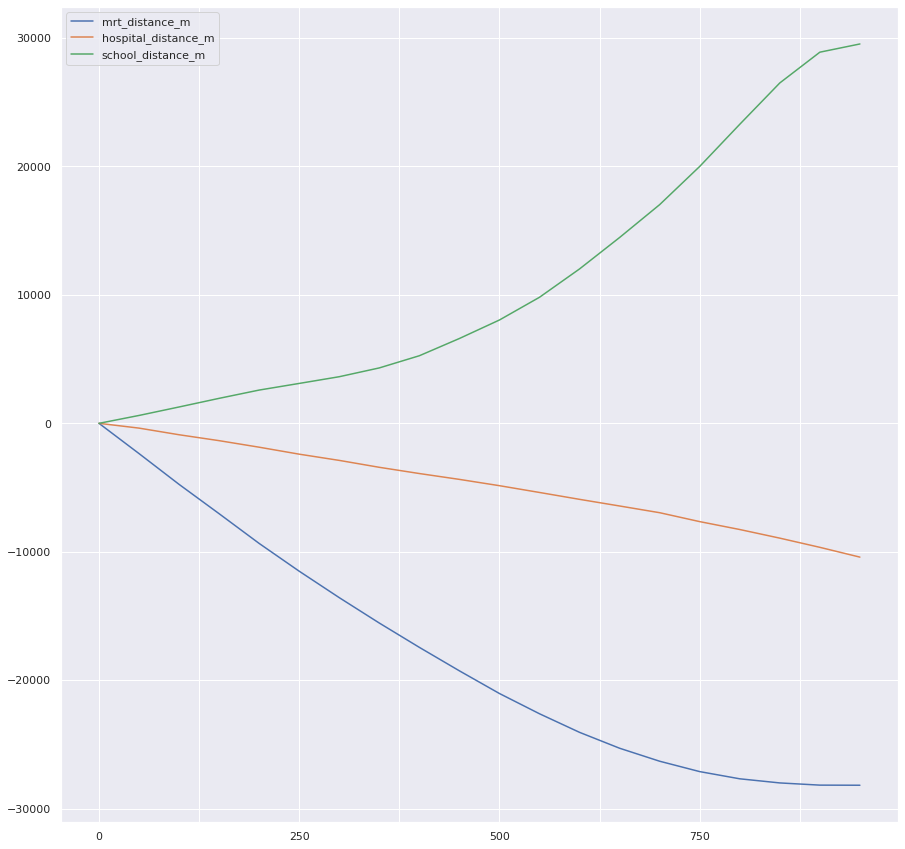

In [31]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca()

for col in amenity_cols:
  plot_variation(col, model=pipes[1], X_cols=X_cols, flats_df=flats_analyse, ax=ax) # Using Gradient Boosting Regressor

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


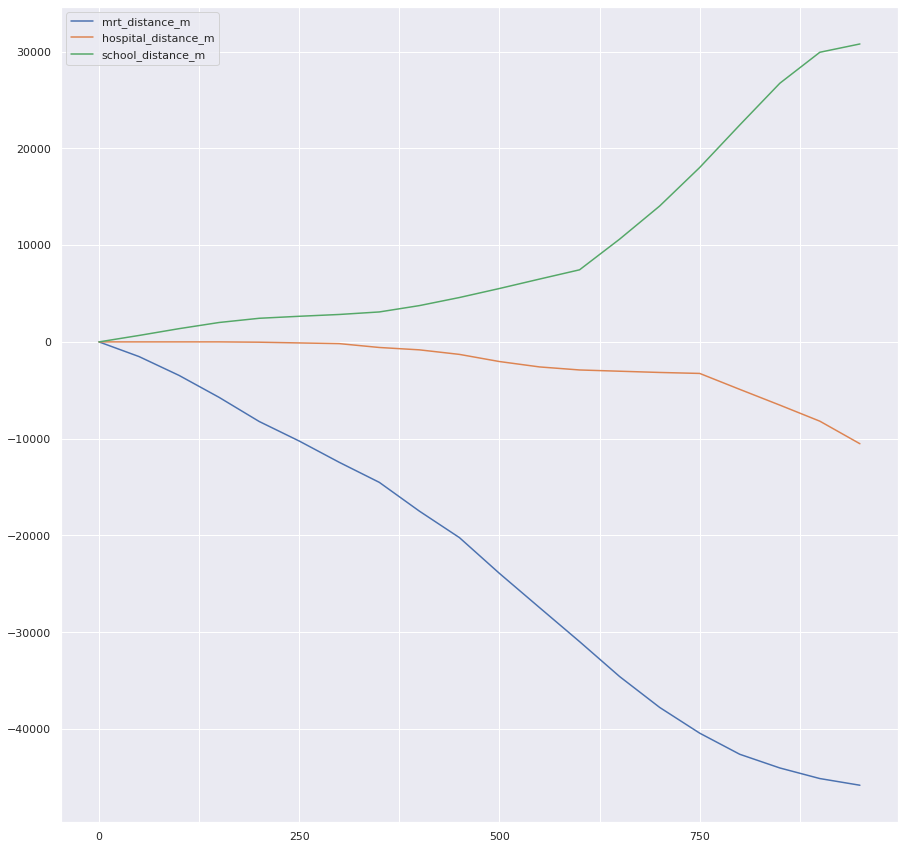

In [34]:
# Assuming the average human walks at 3 miles per hour (google maps) which is 80m/min, we only analyse flats that are within WALKING_DISTANCE from the specified amenity ie. flats within walking distance
WALKING_DISTANCE = 400

fig = plt.figure(figsize=(15,15))
ax = fig.gca()

for col in amenity_cols:
  plot_variation(col, model=pipes[1], X_cols=X_cols, flats_df=flats_analyse[flats_analyse[col]<WALKING_DISTANCE], ax=ax) # Using Gradient Boosting Regressor

                   resale_price  mrt_distance  hospital_distance  school_distance
resale_price           1.000000     -0.109492          -0.113523         0.008743
mrt_distance          -0.109492      1.000000          -0.031113         0.071257
hospital_distance     -0.113523     -0.031113           1.000000        -0.017184
school_distance        0.008743      0.071257          -0.017184         1.000000


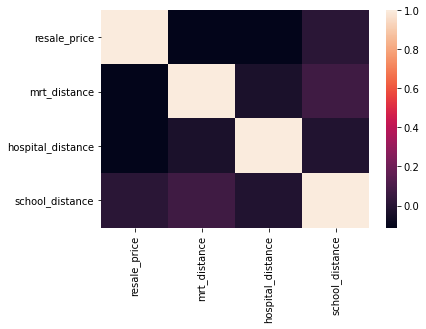

In [ ]:
# Pearson correlation between resale prices and distances to 1) closest MRTs, 2) closest hospitals, 3) closest schools
pearson_amenity = flats_analyse[amenity_cols].corr(method="pearson")
print(pearson_amenity)
sns.heatmap(pearson_amenity)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

<Figure size 432x288 with 0 Axes>

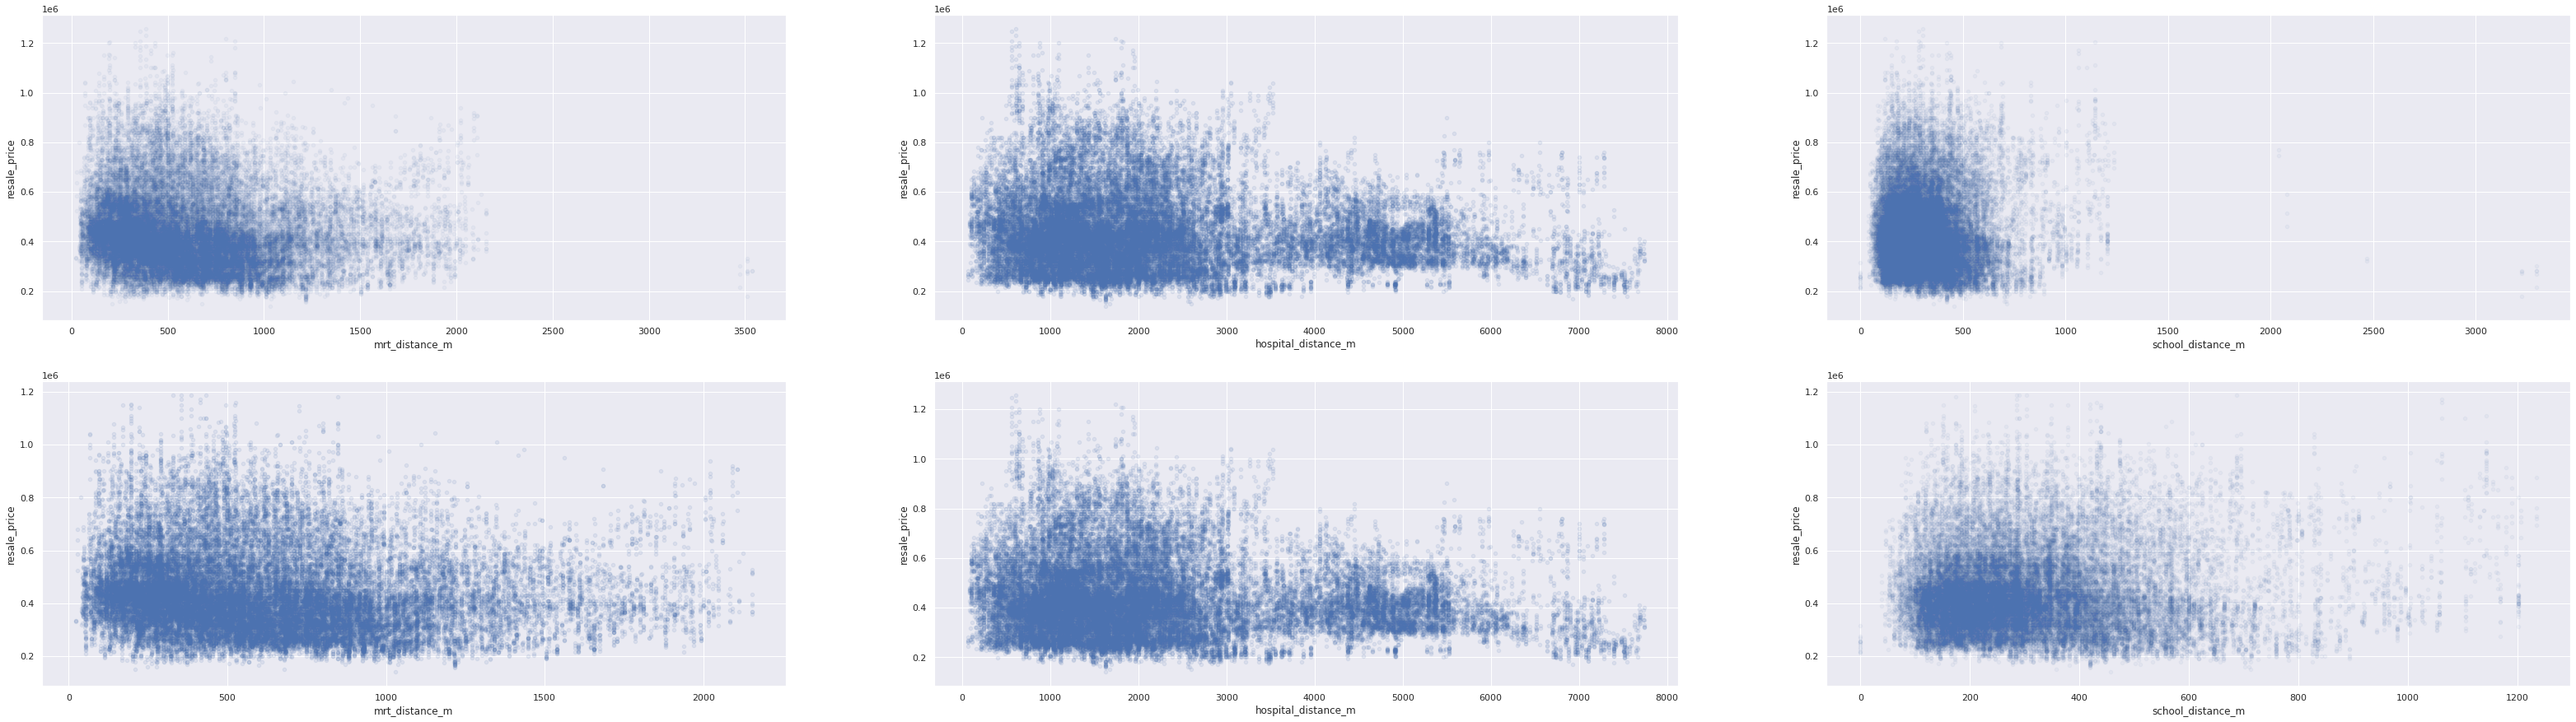

In [182]:
# Visualising correlation between resale prices and distances to 1) closest MRTs, 2) closest hospitals, 3) closest schools
plt.clf()
fig, ax = plt.subplots(2,3, figsize=(55,15))
flats_analyse.plot.scatter(y="resale_price", x="mrt_distance_m", alpha=0.05, ax=ax[0][0])
flats_analyse.plot.scatter(y="resale_price", x="hospital_distance_m", alpha=0.1, ax=ax[0][1])
flats_analyse.plot.scatter(y="resale_price", x="school_distance_m", alpha=0.05, ax=ax[0][2])
flats_analyse[(flats_analyse["mrt_distance_m"]<2250) & (flats_analyse["resale_price"]<1200000)].plot.scatter(y="resale_price", x="mrt_distance_m", alpha=0.1, ax=ax[1][0])
flats_analyse.plot.scatter(y="resale_price", x="hospital_distance_m", alpha=0.1, ax=ax[1][1])
flats_analyse[(flats_analyse["school_distance_m"]<1250) & (flats_analyse["resale_price"]<1200000)].plot.scatter(y="resale_price", x="school_distance_m", alpha=0.05, ax=ax[1][2])
plt.show()

# Appendix and Sanity Checks

In [ ]:
# rad = 750            #radius for search later on; can change if required.
# size = 100          #size of the sample up to 122794.
# gmaps = googlemaps.Client(key = API_KEY)

# df = pd.read_csv('a.csv')
# df2 = df.sample(frac = size/122794)
# df2["mall"] = ' '
# df2["hospital"] = ' '
# df2["worship"] = ' '

# error = 0
# counter = 0
# for label, row in df2.iterrows():
#   try:

#     #get lat/long of the place
#     x = row['block_street_name']
#     z = x.replace(" ", "%2C")
#     print(x + ": ")
#     url = "https://maps.googleapis.com/maps/api/place/findplacefromtext/json?input=" + z + "&inputtype=textquery&fields=formatted_address%2Cname%2Cgeometry&key=" + API_KEY
#     payload={}
#     headers = {}
#     response = requests.request("GET", url, headers=headers, data=payload)
#     lol = json.loads(response.text)
#     lat = str(lol['candidates'][0]['geometry']['location']['lat'])
#     lng = str(lol['candidates'][0]['geometry']['location']['lng'])

#     #get distance of amenities (requires lat/long)
#     #mall
#     has = 0 #check if the amenity is there at all
#     url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json?location="+lat+"%2C"+lng+"&radius="+str(rad)+"&type=shopping_mall&key="+API_KEY
#     payload={}
#     headers = {}
#     response = requests.request("GET", url, headers=headers, data=payload)
#     lol2 = json.loads(response.text)
#     for y in lol2['results']:
#       if 'mall' in y['name'].lower() or 'centre' in y['name'].lower():
#         print("1 mall found: " + y['name'])
#         df2.at[label, 'mall'] = 'Y'
#         has = 1
#       if has == 1:
#         break
    
#     if has == 0:
#       print("no mall found.")
#       df2.at[label, 'mall'] = 'N'


#     #hospital
#     has = 0 
#     url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json?location="+lat+"%2C"+lng+"&radius="+str(rad)+"&type=hospital&key="+API_KEY
#     payload={}
#     headers = {}
#     response = requests.request("GET", url, headers=headers, data=payload)
#     lol2 = json.loads(response.text)
#     for y in lol2['results']:
#       if 'hospital' in y['name'].lower():
#         print("1 hospital found: " + y['name'])
#         df2.at[label, 'hospital'] = 'Y'
#         has = 1
#       if has == 1:
#         break
    
#     if has == 0:
#       print("no mall found.")
#       df2.at[label, 'hospital'] = 'N'
    

#     #place of worship
#     has = 0 
#     url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json?location="+lat+"%2C"+lng+"&radius="+str(rad)+"&type=place_of_worship&key="+API_KEY
#     payload={}
#     headers = {}
#     response = requests.request("GET", url, headers=headers, data=payload)
#     lol2 = json.loads(response.text)
#     for y in lol2['results']:
#       if 'mosque' in y['name'].lower() or 'masjid' in y['name'].lower() or 'church' in y['name'].lower() or 'temple' in y['name'].lower() or 'faith' in y['name'].lower() or 'assembly' in y['name'].lower():
#         print("1 worship place found: " + y['name'])
#         df2.at[label, 'worship'] = 'Y'
#         has = 1
#       if has == 1:
#         break
    
#     if has == 0:
#       print("no worship place found.")
#       df2.at[label, 'worship'] = 'N'  

#     print("so far: "+str(counter))
#     counter = counter+1
#     print("-------------------------")

#   except: #in case error occurs, just mark all as N and move on.
#     print("error somewhere")
#     counter=counter+1
#     error=error+1
#     df2.at[label, 'worship'] = 'N'
#     df2.at[label, 'hospital'] = 'N' 
#     df2.at[label, 'mall'] = 'N'  
#     print("-------------------------")

# print("out of " + str(counter) + " data, "+ str(error) + " gave erorrs.")
# df2.to_csv('b.csv')

In [ ]:
# Looking at which flats are the furthest from a school
flats_analyse[flats_analyse["school_distance"]>1.5].groupby(["street_name", "block"]).mean().sort_values("school_distance", ascending=False)

floor_area_sqm  remaining_lease  resale_price  \
street_name       block                                                  
CHANGI VILLAGE RD 4                66.0             40.0      280000.0   
                  1                66.0             40.0      300000.0   
                  5                66.0             39.0      273900.0   
KENT RD           54              122.5             38.0      757500.0   

                         mrt_distance  number_lines  hospital_distance  \
street_name       block                                                  
CHANGI VILLAGE RD 4          3.535264           1.0           3.905897   
                  1          3.473317           1.0           3.869562   
                  5          3.510793           1.0           3.850685   
KENT RD           54         0.457411           1.0           1.377552   

                         school_distance  
street_name       block                   
CHANGI VILLAGE RD 4             3.296561  
                  1             3.294451  
                  5             3.224690  
KENT RD           54            2.037931

<Figure size 432x288 with 0 Axes>

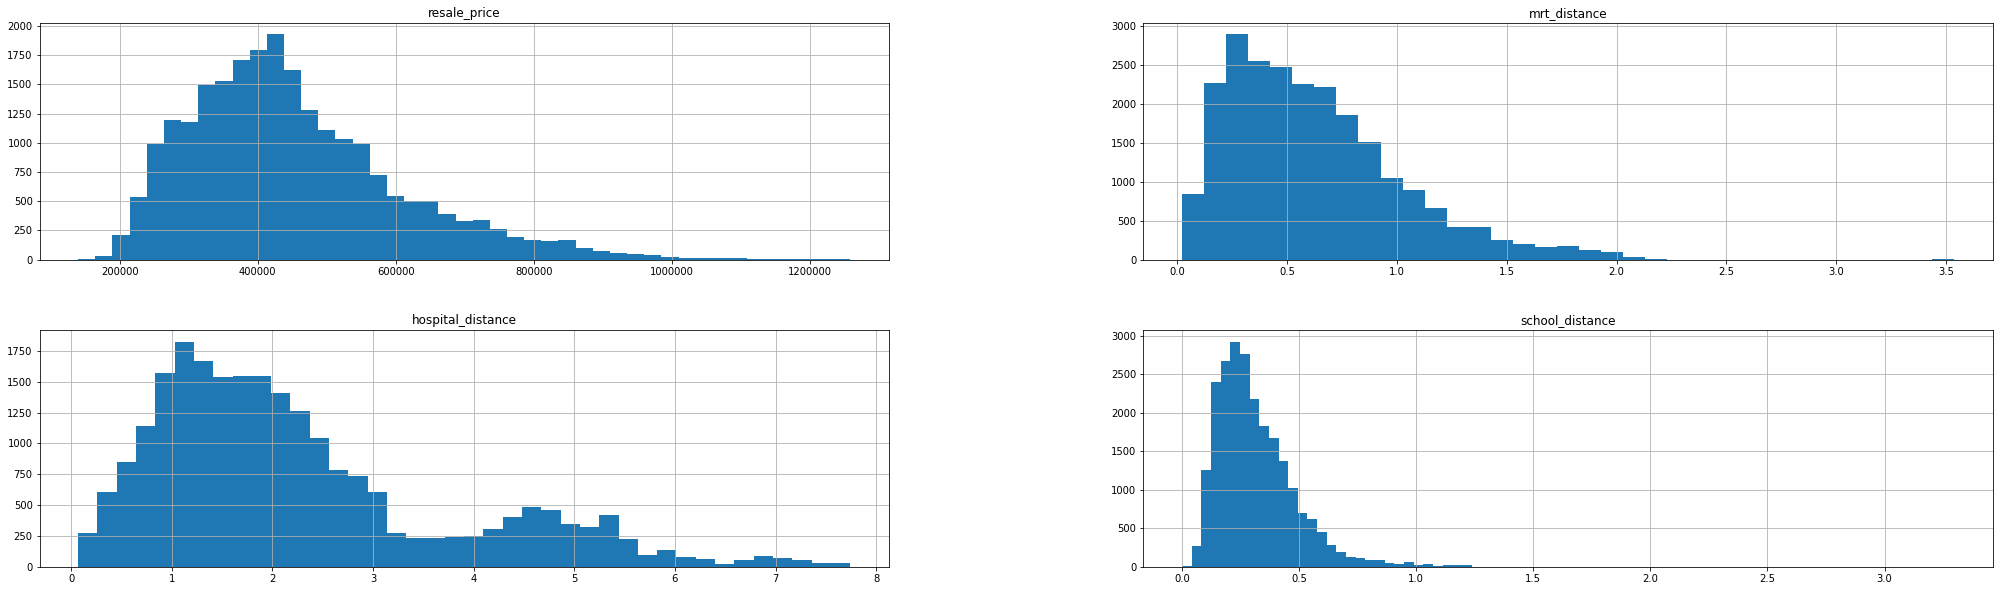

In [ ]:
# Distribution of resale prices, and distances to closest MRTs, closest hospitals, closest schools
plt.clf()
fig, ax = plt.subplots(2,2, figsize=(35,10))
flats_analyse.hist("resale_price", bins=45, ax=ax[0][0])
ax[0][0].ticklabel_format(useOffset=False, style='plain')
flats_analyse.hist("mrt_distance", bins=35, ax=ax[0][1])
flats_analyse.hist("hospital_distance", bins=40, ax=ax[1][0])
flats_analyse.hist("school_distance", bins=80, ax=ax[1][1])
plt.show()

       resale_price  mrt_distance  hospital_distance  school_distance
count  2.333300e+04  23333.000000       23333.000000     23333.000000
mean   4.522794e+05      0.623756           2.275139         0.315397
std    1.545004e+05      0.392460           1.507826         0.173958
min    1.400000e+05      0.022420           0.070800         0.000000
25%    3.400000e+05      0.315988           1.176559         0.192858
50%    4.250000e+05      0.550446           1.881963         0.281116
75%    5.340000e+05      0.832506           2.893736         0.398470
max    1.258000e+06      3.535264           7.740590         3.296561


<Figure size 432x288 with 0 Axes>

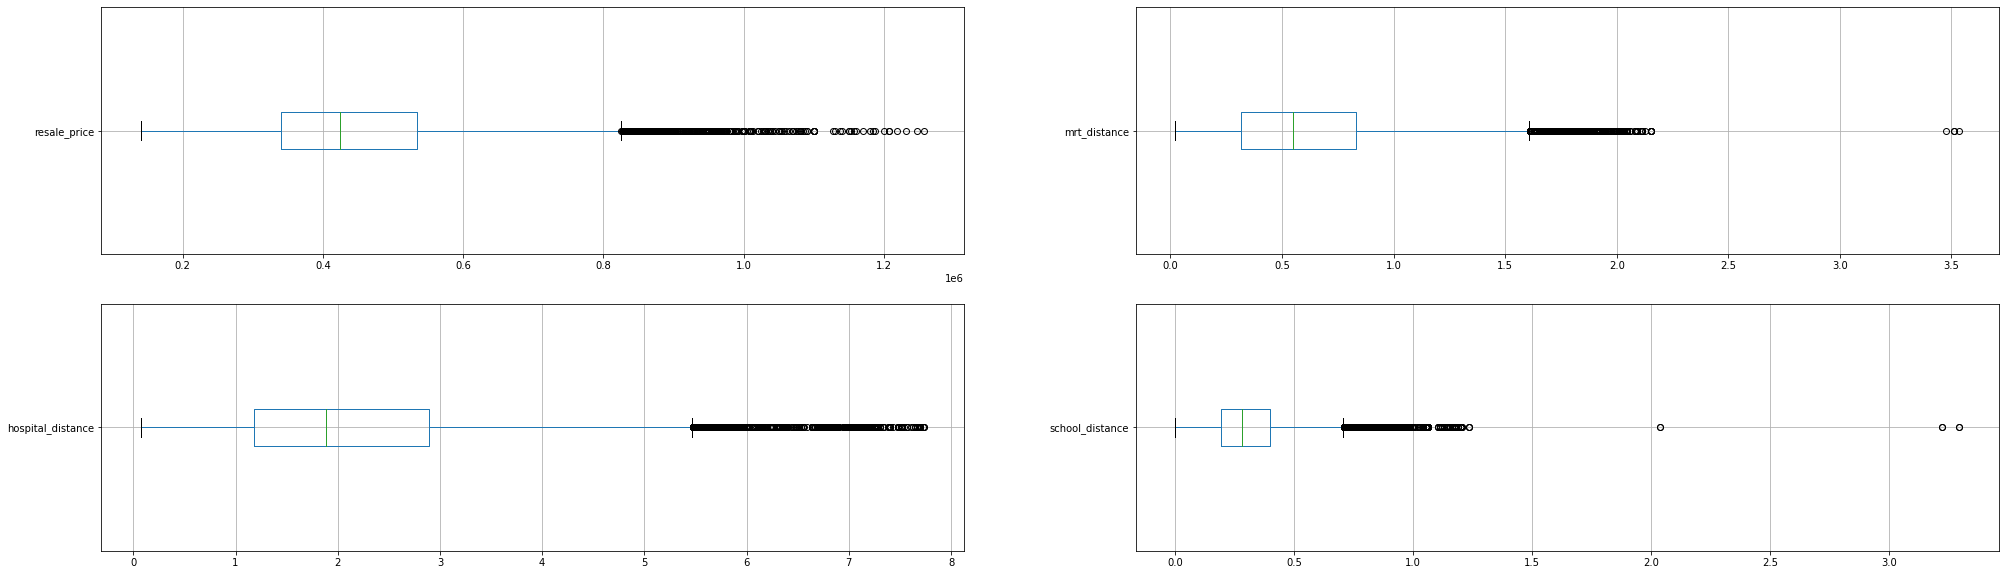

In [ ]:
# Summary statistics of resale prices, and distances to closest MRTs, closest hospitals, closest schools
print(flats_analyse[amenity_cols].describe())
plt.clf()
fig, ax = plt.subplots(2,2, figsize=(34,10))
flats_analyse.boxplot("resale_price", vert=False, ax=ax[0][0])
flats_analyse.boxplot("mrt_distance", vert=False, ax=ax[0][1])
flats_analyse.boxplot("hospital_distance", vert=False, ax=ax[1][0])
flats_analyse.boxplot("school_distance", vert=False, ax=ax[1][1])